In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fungsi untuk menghitung FFT

In [16]:
def fourier(v, nhar):
    # Fungsi untuk menghitung FFT
    npts    = len(v)
    f       = 2.0/npts
    t       = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    vmn     = np.mean(v)
    v       = v - vmn
    cofs    = [0]*(nhar+1)
    cofs[0] = (vmn,0)
    for i in range(1,nhar+1):
        c, s    = np.cos(i*t), np.sin(i*t)
        cofs[i] = (np.dot(v,c)*f, np.dot(v,s)*f)
    return (cofs)

Fungsi untuk menghitung nilai sintesis dari FFT

In [17]:
def fourier_synth(cofs, npts):
    # Fungsi untuk menghitung nilai sintesis dari FFT
    nt  = len(cofs)
    syn = np.zeros(npts)
    t  = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    for n in range(1, nt):
        for j in range(npts):
            syn[j] += cofs[n][0]*np.cos(n*t[j]) + cofs[n][1]*np.sin(n*t[j])
    return (syn)

Baca data

In [18]:
fileinput = 'tun20181104qmin.min'
code = fileinput[0:3].upper()
data = pd.read_csv(fileinput, skiprows=16, sep='\s+')

Hilangkan nilai rata-rata harian

In [19]:
H = (data[code + 'H'] - data[code + 'H'].mean()).values
D = (data[code + 'D'] - data[code + 'D'].mean()).values
Z = (data[code + 'Z'] - data[code + 'Z'].mean()).values

Hitung nilai FFT di setiap komponen

In [20]:
n_harmonics=3
hcofs = fourier(H, n_harmonics)
synh  = fourier_synth(hcofs, len(H))
dcofs = fourier(D, n_harmonics)
synd  = fourier_synth(dcofs, len(D))
zcofs = fourier(Z, n_harmonics)
synz  = fourier_synth(zcofs, len(Z))

Plot data

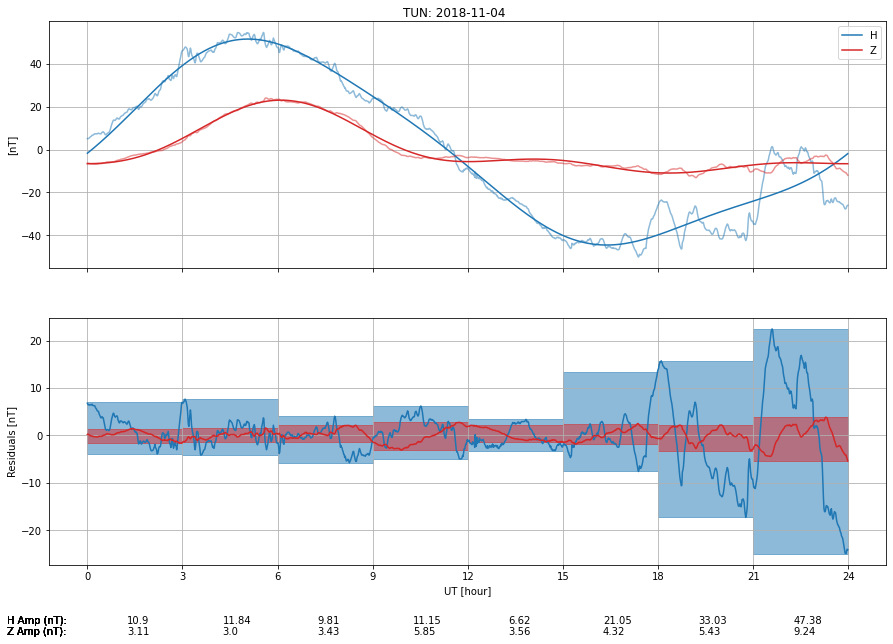

In [21]:
# Build plot
t = np.linspace(0, 1440, 1440, endpoint=False)/60
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# Plot X & Y data with approximated variation
axes[0].plot(t, H, color="tab:blue", alpha=0.5)
axes[0].plot(t, synh, color="tab:blue", label="H")
axes[0].plot(t, Z, color="tab:red", alpha=0.5)
axes[0].plot(t, synz, color="tab:red", label="Z")
# Plot the differences
axes[1].plot(t, (H-synh), color="tab:blue")
axes[1].plot(t, (Z-synz), color="tab:red")

# Find and plot min/max bounds over 3-hourly intervals
minH = np.min((H-synh).reshape(8, 180), axis=1)
maxH = np.max((H-synh).reshape(8, 180), axis=1)
minZ = np.min((Z-synz).reshape(8, 180), axis=1)
maxZ = np.max((Z-synz).reshape(8, 180), axis=1)
t_3hours = np.linspace(0, 1440, 9, endpoint=True)/60
axes[1].fill_between(t_3hours, list(minH)+[0], list(maxH)+[0], step="post", color="tab:blue", alpha=0.5)
axes[1].fill_between(t_3hours, list(minZ)+[0], list(maxZ)+[0], step="post", color="tab:red", alpha=0.5)

# Find max amp over 3-hourly intervals
diffH = np.round(maxH-minH, decimals=2)
diffZ = np.round(maxZ-minZ, decimals=2)

for i in range(8):
    axes[1].annotate(
                f"{diffH[i]}\n{diffZ[i]}",
                (i*3, axes[1].get_ylim()[0]), xytext=(40, -70), textcoords="offset pixels"
            )
    axes[1].annotate(
        f"H Amp (nT):\nZ Amp (nT):",
        (0, axes[1].get_ylim()[0]), xytext=(-80, -70), textcoords="offset pixels"
    )
# Finalise figure
for ax in axes:
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0, 27, 3))
axes[1].set_ylabel("Residuals [nT]")
axes[1].set_xlabel("UT [hour]")
axes[0].set_ylabel("[nT]")
axes[0].legend(loc="upper right")
fig.suptitle(f"{code}: {data['DATE'].iloc[0]}", y=0.9)

fig.savefig(fileinput[0:15] + '.png', dpi=fig.dpi)